# Soccer Mobile
<!-- Introduction of the project -->

**Students: Chengkun Li, Jiangfan Li, Georgios Apostolides, Lucas Represa**

## I. Introduction

In this project the goal is to combine vision, path planning, local navigation, and filtering in order to make Thymio robot navigate trough a map towards a goal.  

As the constraints are established we were free to chose our own implementation. To begin with, a camera is used in order to provide the vision information. The vision module works along with the global path and filter modules extracting estimating and computing the necessary map information, including the robot pose, robot pose, map, static obstacles, and the goal position. 

Indeed, a Kalman filter performs the estimations of the robot pose. Afterwards, the A* algorithm computes the optimal path. Following this, a global controller gives instructions to the motors for them to follow the optimal path. Finally, a local navigation module is implemented in order to provide a vision-free information to Thymio for the most spontaneous events such as a dynamic obstacle.

## II. Implementation

**Import Libraries**

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import time
import random
from vision import *
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

**Thymio Connection**

In [3]:
import tdmclient.notebook
await tdmclient.notebook.start()

CancelledError: 

**Environment**

In order to create our soccer field environnement we printed an A1 sheet with the corresponding field. Corners are represented by [...]. A camera performs the vision part by transferring frames to the vision module. 

In [ ]:
G_verbose = True

## Geometry

In [ ]:
from geo import *

## Vision


The vision module is responsible for giving the coordinates for different objects of interest. Specifically, the vision module outputs the position of the ball in the field and a map of the obstacles. Additionally, the vision part is responsible for identifying the corners of the field and wrapping the image so that a top planar view of the field can be achieved.


### A) Using Images of the Setup

In this section we explain the operations and functions performed from the vision module using image. This is done in case while running this notebook you don't have the environment setup or the camera in hand.

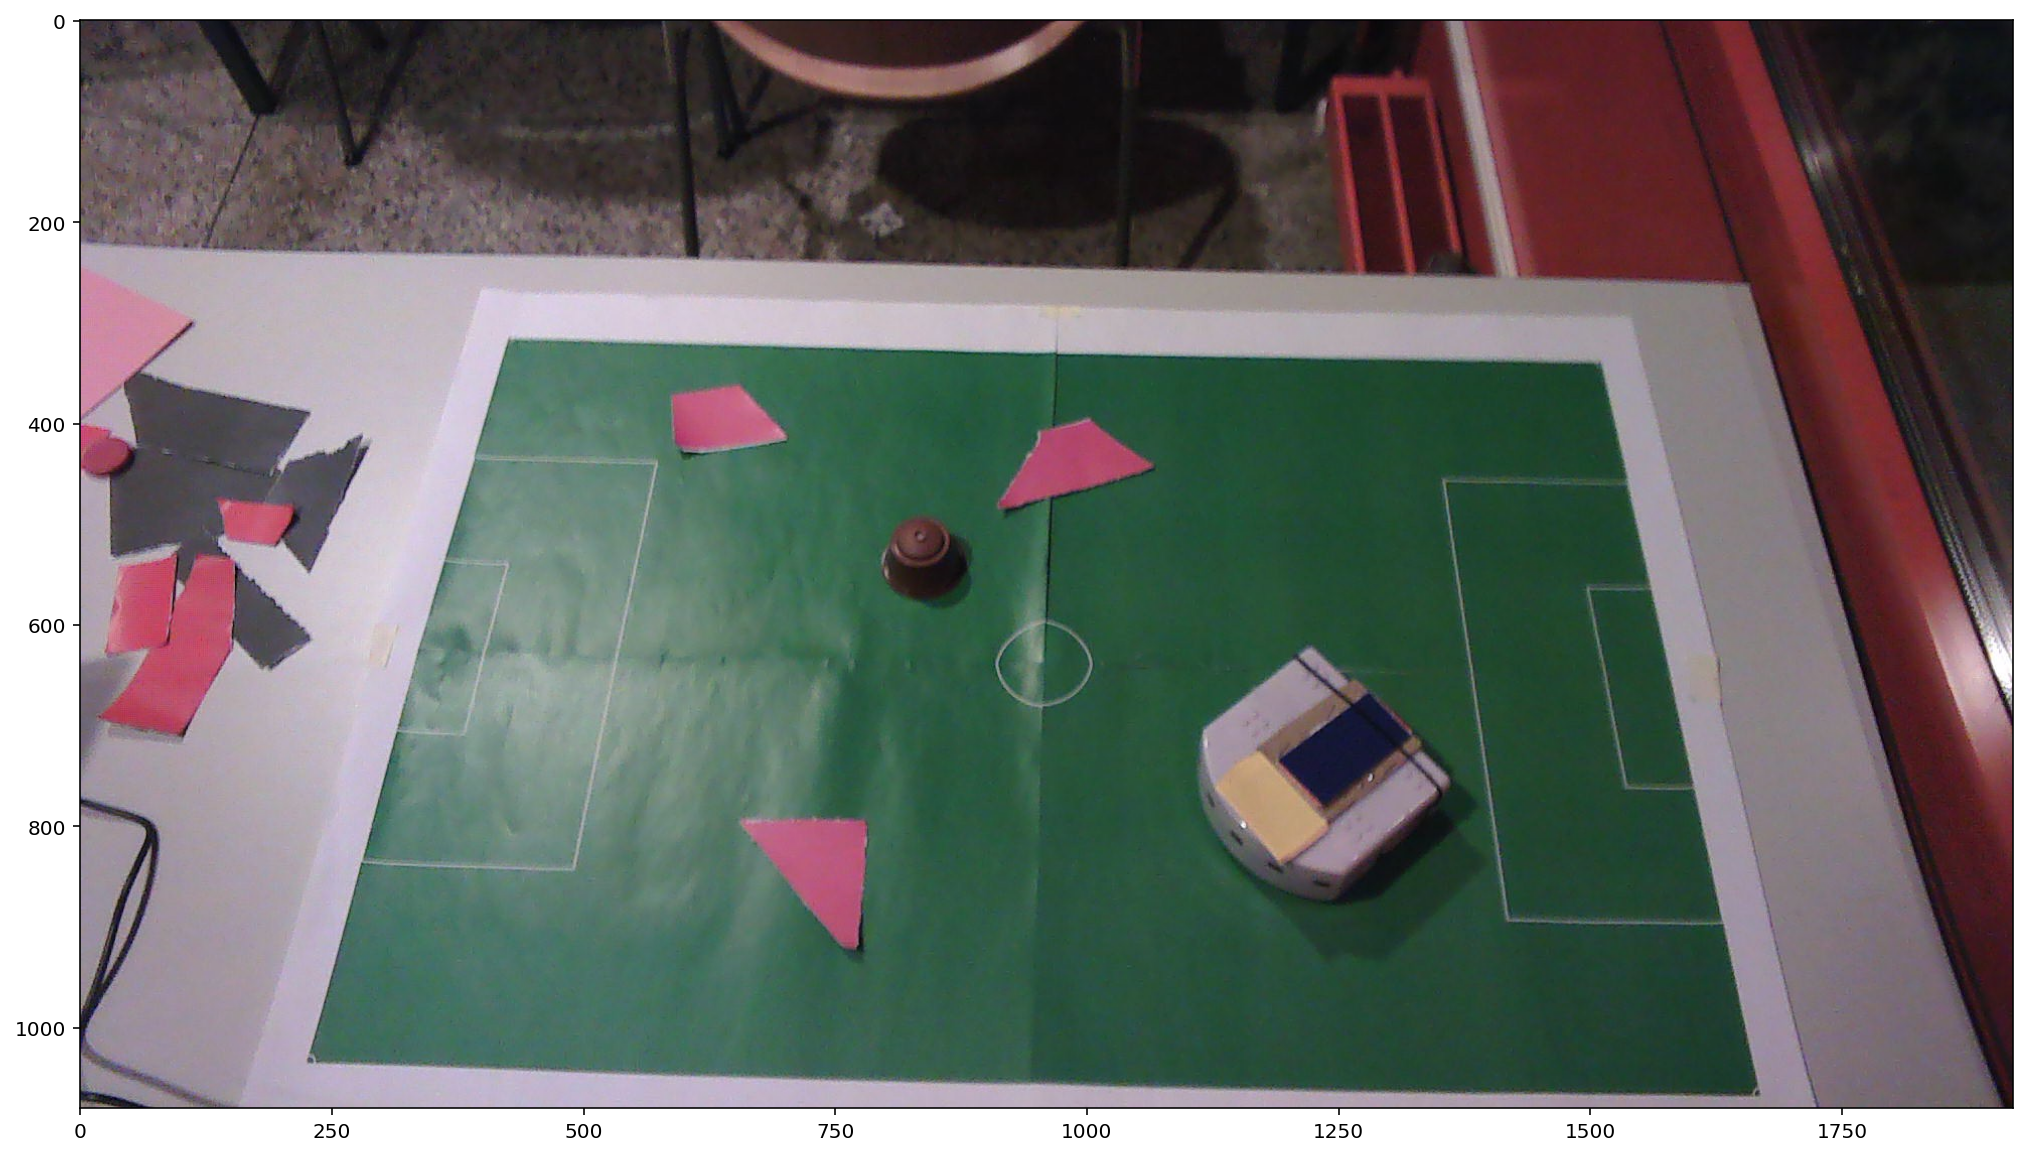

In [6]:
vp = VisionProcessor()
img_thymio = cv2.imread("img/example.jpg")
plt.imshow(cv2.cvtColor(img_thymio, cv2.COLOR_RGB2BGR))

### Align the Field

#### Color Filtering

In order to fascilitate the use of color filtering a function called `color_filter` under the class `VisionProcessor` was createrd. The values of various colors in the HSV color space were preset in order to make the use of color filtering easier. Specifically the following colors where defined so far: red, green, blue, yellow, black, pink, white. If the color doesn't much the above an error is outputted saying so.

`color_filtered_image = VisionProcessor.color_filter(img, color=color)`



- **Output:**
        Color filtered Image

- **Arguments:**

| Argument |                                          Explanation                                          |
|:--------:|:---------------------------------------------------------------------------------------------:|
|   image  |<p style="text-align: left;"> image to be color filtered</p>|
|   color  |<p style="text-align: left;"> color in which to filter the image (i.e.red, green, blue, yellow, black, pink, white)</p> |


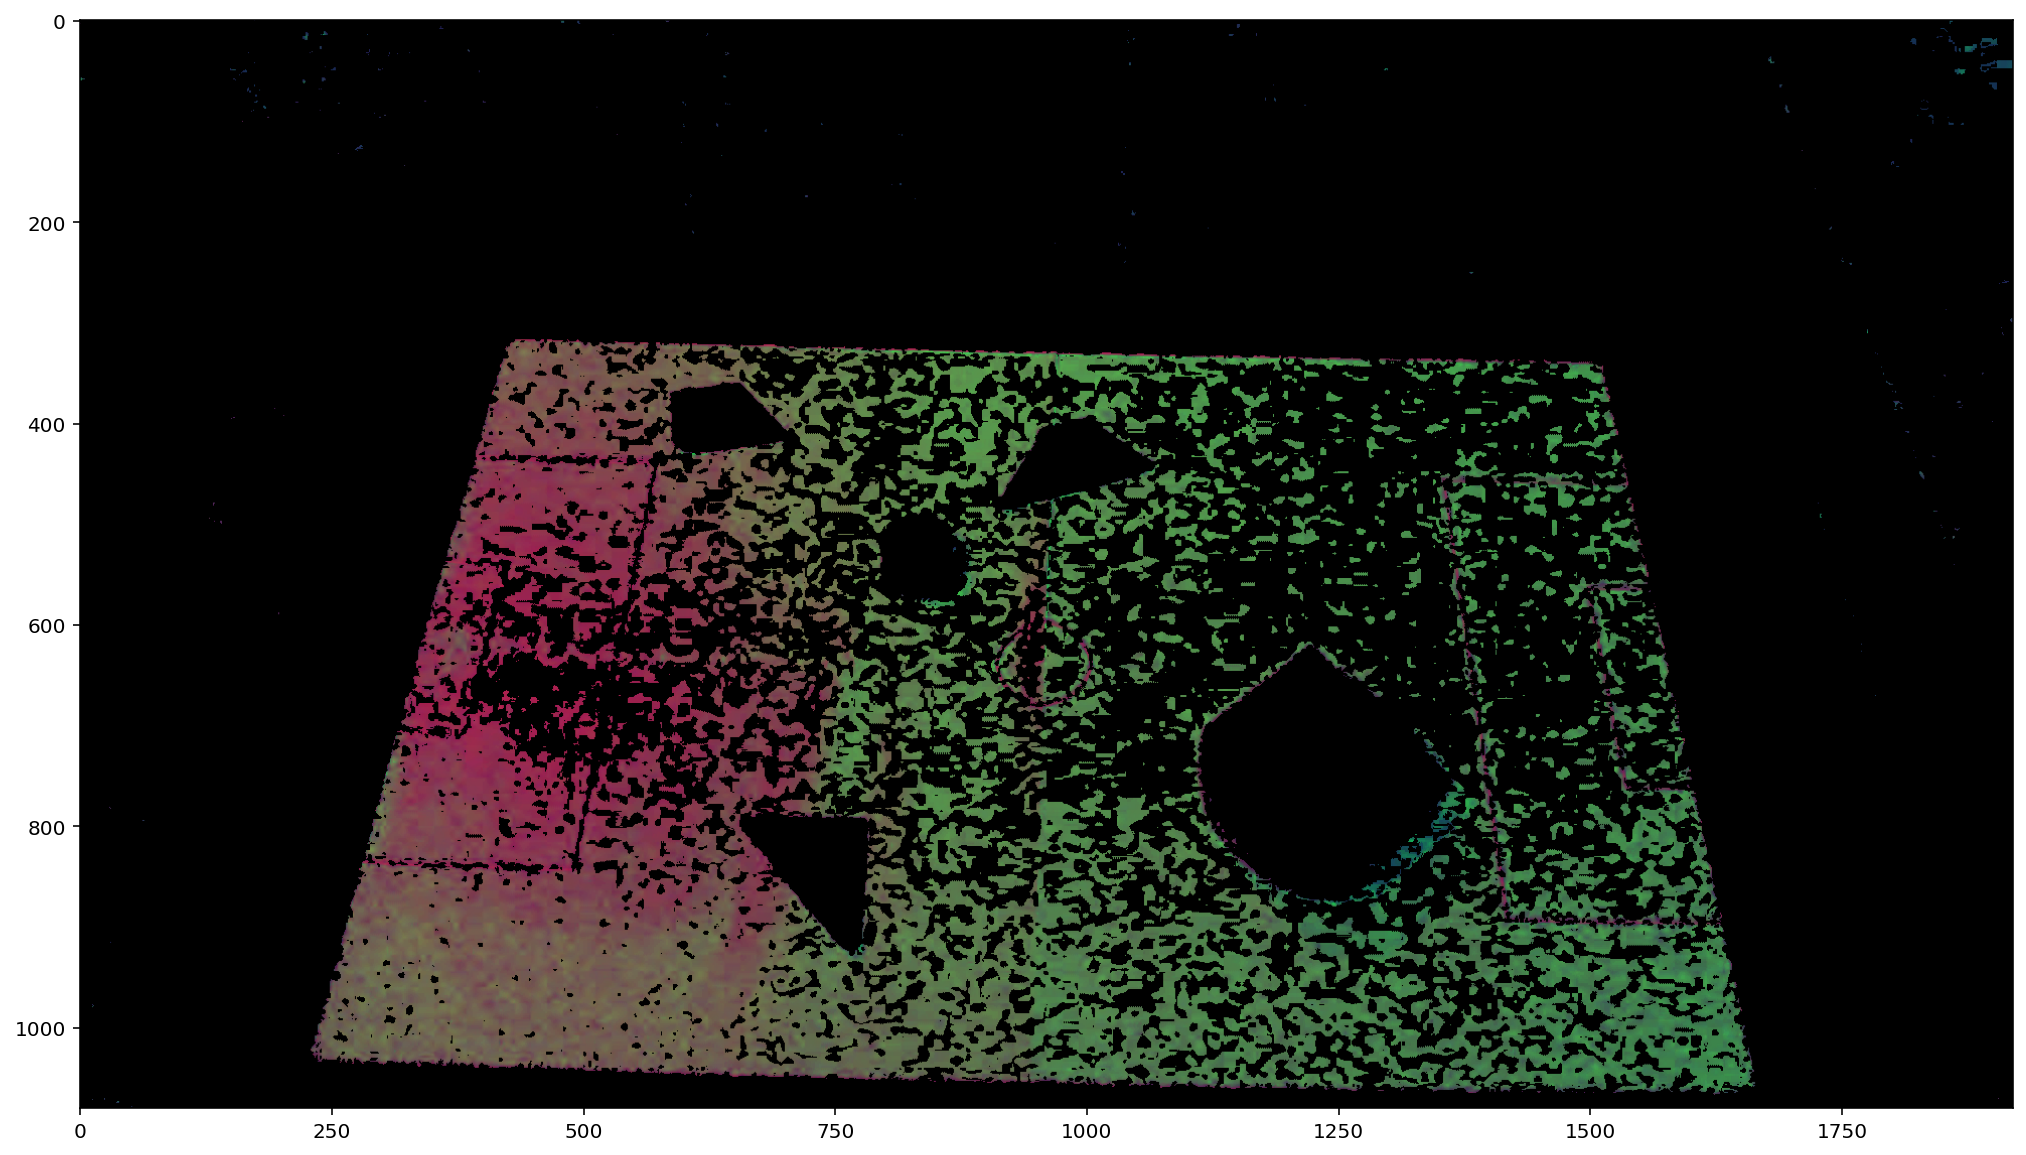

In [7]:
color = 'green'
green_mask = VisionProcessor.color_filter(img_thymio, color=color)
plt.imshow(cv2.cvtColor(green_mask, cv2.COLOR_RGB2BGR))

#### Corner Detection

This section demonstrates to methods which were developed for identifying the corners of the field. The first method uses image processing to detect the corners of the field while the second one uses aruco markers which represents the corners of the field.

##### 1. Using Image Processing

Although this method was developed it is not used in the project as the corner identification was proven to be noisy and to vary with light changes. Nevertheless the method is left here for future reference. 

The method uses the result of color filtering to identify the biggest contour by taking the convex hull of the largest contours. The four corners are then identified using the means of a Gaussian Mixture Model.

In [8]:
# 1. find the biggest green part

gray = cv2.cvtColor(green_mask, cv2.COLOR_BGR2GRAY)
(T, thresh) = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
# morphology operation against noise
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((10, 10)))
# extract contours
_,contours,hierarchy = cv2.findContours(closing,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Taking the one with the largest area # serve as the opening operation to some extent
c = max(contours, key = cv2.contourArea)
# use a convexHull against noise
hull = cv2.convexHull(c)
hull_img = np.zeros_like(img)     
length = len(hull)
for i in range(len(hull)):
    cv2.line(hull_img, tuple(hull[i][0]), tuple(hull[(i+1)%length][0]), (255,0,0), 2)
hull_img = cv2.cvtColor(hull_img, cv2.COLOR_RGB2GRAY)
plt.imshow(hull_img)    
_,convexcontour,_ = cv2.findContours(hull_img,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ch = img.copy()
cv2.drawContours(ch,convexcontour,-1,(255,0,0),1)
#plt.imshow(cv2.cvtColor(ch, cv2.COLOR_RGB2BGR))    

ValueError: not enough values to unpack (expected 3, got 2)

In [9]:
# 2. get 4 corners
lines = VisionProcessor.divide4(np.array(hull))
ll = lines[np.argmax([abs(l[-1]) for l in lines])]
lines.remove(ll)
rl = lines[np.argmax([abs(l[-1]) for l in lines])]
lines.remove(rl)
ul = lines[0]
dl = lines[1]
corners = []
i = 1
ch = img.copy()
for h in [ul, dl]:
    for v in [ll, rl]:
        x, y = VisionProcessor.intersection(h[0], h[1], -h[2], v[0], v[1], -v[2])
        corners.append([x, y])
        print("corner",x, y)
        cv2.circle(ch, (x, y), 3, (0, 255, 0), -1)
        cv2.putText(ch,str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        i += 1
        
corners = np.array(corners)

plt.imshow(ch)

NameError: name 'hull' is not defined

##### 2. Using aruco


To fascilitate the detection of the corners and be invariant to lightiing conditions aruco markers where used at each corner to signify it. By detecting the aruco markers position we are able to detect the pixel position on the image which represents the corner. 

Below, you can see an example from a loaded image:

In [ ]:
img_obs = cv2.imread("img/test.jpg")
plt.imshow(cv2.cvtColor(img_obs, cv2.COLOR_RGB2BGR))

In [ ]:
corners, a_image = vp.visualize_aruco(img_obs)
plt.imshow(cv2.cvtColor(a_image, cv2.COLOR_RGB2BGR))

#### Perspective Projection

The perspective projection section explains how the vision modules takes the four identified corners and returns a planar projection of the field. 

_`align_field`:_ This function which is part of the `VisionProcessor` class is responsible for taking the 4 corners identified before using the aruco markers and returning the perspecive transform `M` between the skewed plane of the field and the rectangle which is formed using the maximum Height and maximum width. To get the perpective transform a function from the OpenCV library is used called `cv2.getPerspectiveTransform` which uses the identified corners and the constructed rectangle corners.

`M = VisionProcessor.align_field(corners)`



- **Output:**
        Perspective Transformation Matrix (M)

- **Arguments:**

| Argument |             Explanation            |
|:--------:|:----------------------------------:|
|  corners | corners array in pixel coordinates |


_`warp`:_ This function which is part of the `VisionProcessor` class is responsible for taking an image and applying the previously calculated transformation. This is done by warping the image using the `cv2.wrapPerspective` function from the OpenCV library.

`warped = VisionProcessor.warp(img, M)`

- **Output:**
        Warped image (warped)

- **Arguments:**

| Argument |                          Explanation                         |
|:--------:|:------------------------------------------------------------:|
|    img   |<p style="text-align: left;">original image which will be wrapped with perspective matrix </p>|
|     M    |<p style="text-align: left;">perspective transformation matrix </p>                          |

In [ ]:
print("Corners' Pixel Coordinates:")
M = vp.align_field(corners)
wraped = VisionProcessor.warp(img_obs, M)
plt.imshow(cv2.cvtColor(wraped, cv2.COLOR_RGB2BGR))

### Get Thymio's Pose

#### Box Detection

One of the expected outputs from the vision class is the pose of the robot. In order to be able to identify the pose of the robot two rectangular colored squares were placed on top of thymio. By finding the center of each of the boxes and connecting them we get a vector pointing to the direction where thymio is traveling.


`(cx,cy) = VisionProcessor.detect_box(image,color='yellow',verbose=False)`


- **Output:**
        Cartesian Pixel Coordinates for the center of the box to be detected.
        
- **Arguments:**

| Argument |                         Explanation                         |
|:--------:|:-----------------------------------------------------------:|
|   image  |<p style="text-align: left;">image on which the box will be detected</p>|
|   color  |<p style="text-align: left;">color of the box to be filtered. </p>|
| verbose  |<p style="text-align: left;">Used for displaying the intermediate steps while debugging.</p>|

In [ ]:
plt.imshow(cv2.cvtColor(img_thymio, cv2.COLOR_BGR2RGB))

In [ ]:
(cx_blue,cy_blue)=VisionProcessor.detect_box(img_thymio,color='blue',verbose=False)
(cx_yellow,cy_yellow)=VisionProcessor.detect_box(img_thymio,color='yellow',verbose=False)
cv2.circle(img_thymio,(cx_blue,cy_blue),1,(0,255,0),12);
cv2.circle(img_thymio,(cx_yellow,cy_yellow),1,(0,255,0),12);
plt.imshow(cv2.cvtColor(img_thymio, cv2.COLOR_BGR2RGB))

#### Get Robot's Pose

_`get_robot_pose`:_ Receives as an input a frame which contains the robot. It uses the `detect_box` function demonstrated above to find the centers of the boxes on thymio. Then it uses them to define the Pose of thymion     (x, y, $\theta$ ) using the displacement from the origin. The pose of the robot is scaled into physical distances using the FieldScale.

`(robot_xy,robot_angle) = get_robot_pose(image, verbose = False)`

- **Output:**
   Robot Cartesian Position in physical distances and robots orientation in radians.

- **Arguments:**

| Argument |                         Explanation                         |
|:--------:|:-----------------------------------------------------------:|
|   image  |<p style="text-align: left;">image on which the robot will be detected</p>|
| verbose  |<p style="text-align: left;">Used for displaying the intermediate steps while debugging.</p>|




In [ ]:
img_thymio2 = cv2.imread("img/example.jpg")

#Drawing State vector on a new image
state = VisionProcessor.get_robot_pose(img_thymio, verbose = False)
cv2.arrowedLine(img_thymio2,(cx_blue,cy_blue), (cx_yellow,cy_yellow), color=(0,255,0), thickness=8)
cv2.circle(img_thymio2,(cx_blue,cy_blue),1,(0,0,255),12);

#Outputing the state of the robot
print("     X            Y                  Theta \n",state)
plt.imshow(cv2.cvtColor(img_thymio2, cv2.COLOR_BGR2RGB))

### Ball Detection

_`get_ball_xy`:_ Part of the class Vision processor used to identify the position of the ball in the field. It receives as an input an image of the field with the ball. The image is first color filtered based on the `color` argument passed. In our case we use the green color the reason is because the ball is circular at the botom it leaves a black circle on the green surface which can be identified. Thresholding and a median filder for smoothing is applied on the color filtered image. A function from the OpenCV library is used to detect circles in the image. More information for the `cv2.HoughCircles` can be found [here](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d) and [here](https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html). The function returns the XY pixel coordinates of the identified circle.

``ball_pos=VisionProcessor.get_ball_xy(wraped,color = "green", minDist = 850, param1 = 12,param2 = 22,``\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;``minRadius = 20,maxRadius = 55,verbose = True)``

- **Outputs:**
        Used to output the position of the ball in the field in pixel coordinates.
- **Arguments:**

|  Argument |<p style="text-align: center;">                                                                   Explanation      </p>                                                    |
|:---------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|   image   | image on which the box will be detected                                                                                                                               |
|   color   | color of the box to be filtered                                                                                                                                       |
| minDist   | Minimum distance between the centers of the detected circles. If too large circles may be missed, if too small too many circles may appear.                           |
| param1    | Method uses canny filter edge detection.This is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller of the larger one). |
| param2    | Accumulator threshold for the circle centers at the detection stage.The smaller it is, the more false circles may be detected.                                        |
| minRadius | Min radius of circle to detect                                                                                                                                        |
| maxRadius | Max radius of circle to detect                                                                                                                                        |
| verbose   | Used for displaying the intermediate steps while debugging.                                                                                                           |

In [ ]:
ball_img=wraped.copy()
# wraped = VisionProcessor.warp(ball_img, M)

ball_pos=VisionProcessor.get_ball_xy(ball_img,color = "green", minDist = 850, param1 = 12,param2 = 22,
                                     minRadius = 20,maxRadius = 55,verbose = True)
cv2.circle(ball_img,ball_pos,1,(0,0,255),12);
plt.imshow(cv2.cvtColor(ball_img, cv2.COLOR_RGB2BGR))

### Build a Map

_`obstacle_map`:_ This function is used to color filter obstacles in the `color` passed as argument and form a binary map of the field. The function receives as input the image in which the obstacles need to be detected. A Gaussian Blur filter is applied to smoothened the image. The scene is colored filtered with the given color argument in our case with the pink color. Erossion and dilation is applied to remove noise from the map.

`map = VisionProcessor.obstacles_map(image, color = 'pink', blur_kernel = (19, 19), verbose = False)`


- **Output:**
        Binary Map of the image passed. Obstacles Represented in black color (map)
        
- **Arguments:**

| Argument |                         Explanation                         |
|:--------:|:-----------------------------------------------------------:|
|   image  |<p style="text-align: left;">image on which the map will be formed</p>|
|   blur_kernel  |<p style="text-align: left;">size of the Gaussian Kernel to be applied. </p>|
|   color  |<p style="text-align: left;">color of the obstacels to be filtered. </p>|
| verbose  |<p style="text-align: left;">Used for displaying the intermediate steps while debugging.</p>|

In [ ]:
plt.imshow(cv2.cvtColor(wraped, cv2.COLOR_RGB2BGR))

In [ ]:
map=VisionProcessor.obstacles_map(wraped, color = 'pink', blur_kernel = (21, 21), verbose = False)

plt.imshow(map)

### B) Using the Camera Feed

In [ ]:
from vision import *

In [ ]:
# Initialize the camera
vp = VisionProcessor(camera_index=0)
_ = vp.open()

### Align the Field

#### Color Filtering

In order to fascilitate the use of color filtering a function called `color_filter` under the class `VisionProcessor` was createrd. The values of various colors in the HSV color space were preset in order to make the use of color filtering easier. Specifically the following colors where defined so far: red, green, blue, yellow, black, pink, white. If the color doesn't much the above an error is outputted saying so.

`color_filtered_image = VisionProcessor.color_filter(img, color=color)`



- **Output:**
        Color filtered Image

- **Arguments:**

| Argument |                                          Explanation                                          |
|:--------:|:---------------------------------------------------------------------------------------------:|
|   image  |<p style="text-align: left;"> image to be color filtered</p>|
|   color  |<p style="text-align: left;"> color in which to filter the image (i.e.red, green, blue, yellow, black, pink, white)</p> |


#### Using Aruco Markers to detect corners

In this part we get the pixel coordinates of all four corners by using the aruco markers.

In [ ]:
img = cv2.imread("img/test.jpg")
corners, a_image = vp.visualize_aruco(img)
corners
plt.imshow(cv2.cvtColor(a_image, cv2.COLOR_RGB2BGR))

#### Perspective Projection

The perspective projection section explains how the vision modules takes the four identified corners and returns a planar projection of the field. 

_`align_field`:_ This function which is part of the `VisionProcessor` class is responsible for taking the 4 corners identified before using the aruco markers and returning the perspecive transform `M` between the skewed plane of the field and the rectangle which is formed using the maximum Height and maximum width. To get the perpective transform a function from the OpenCV library is used called `cv2.getPerspectiveTransform` which uses the identified corners and the constructed rectangle corners.

`M = VisionProcessor.align_field(corners)`



- **Output:**
        Perspective Transformation Matrix (M)

- **Arguments:**

| Argument |             Explanation            |
|:--------:|:----------------------------------:|
|  corners | corners array in pixel coordinates |


_`warp`:_ This function which is part of the `VisionProcessor` class is responsible for taking an image and applying the previously calculated transformation. This is done by warping the image using the `cv2.wrapPerspective` function from the OpenCV library.

`warped = VisionProcessor.warp(img, M)`

- **Output:**
        Warped image (warped)

- **Arguments:**

| Argument |                          Explanation                         |
|:--------:|:------------------------------------------------------------:|
|    img   |<p style="text-align: left;">original image which will be wrapped with perspective matrix </p>|
|     M    |<p style="text-align: left;">perspective transformation matrix </p>                          |




In [ ]:
# corners = vp.corners_ar()
M = VisionProcessor.align_field(corners)
# img = vp._getImage()
warped = vp.warp(img, M)
pose = vp.get_robot_pose(warped, verbose=True)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

### Get the robot state with camera

In [ ]:
def camera_state(vp, M):
    img = vp._getImage()
    warped = vp.warp(img, M)
    state = vp.get_robot_pose(warped)
    return state

In [ ]:
if camera_state(vp, M) is not None:
    print('The Thymio is still on the map! Remove it!')

#### Box Detection

One of the expected outputs from the vision class is the pose of the robot. In order to be able to identify the pose of the robot two rectangular colored squares were placed on top of thymio. By finding the center of each of the boxes and connecting them we get a vector pointing to the direction where thymio is traveling.


`(cx,cy) = VisionProcessor.detect_box(image,color='yellow',verbose=False)`


- **Output:**
        Cartesian Pixel Coordinates for the center of the box to be detected.
        
- **Arguments:**

| Argument |                         Explanation                         |
|:--------:|:-----------------------------------------------------------:|
|   image  |<p style="text-align: left;">image on which the box will be detected</p>|
|   color  |<p style="text-align: left;">color of the box to be filtered. </p>|
| verbose  |<p style="text-align: left;">Used for displaying the intermediate steps while debugging.</p>|
        
        

In [ ]:
img_thymio = warped
plt.imshow(cv2.cvtColor(img_thymio, cv2.COLOR_BGR2RGB))

In [ ]:
(cx_blue,cy_blue)=VisionProcessor.detect_box(img_thymio,color='blue',verbose=False)
(cx_yellow,cy_yellow)=VisionProcessor.detect_box(img_thymio,color='yellow',verbose=False)
cv2.circle(img_thymio,(cx_blue,cy_blue),1,(0,255,0),12);
cv2.circle(img_thymio,(cx_yellow,cy_yellow),1,(0,255,0),12);
plt.imshow(cv2.cvtColor(img_thymio, cv2.COLOR_BGR2RGB))

#### Ball Detection

In [ ]:
wraped = VisionProcessor.warp(img, M)
ball_pos=VisionProcessor.get_ball_xy(wraped,color = "green", minDist = 850,param1 = 19,param2 = 12,
                                     minRadius = 42,maxRadius = 45,verbose = True)
cv2.circle(wraped,ball_pos,1,(0,0,255),12);
plt.imshow(cv2.cvtColor(wraped, cv2.COLOR_RGB2BGR))

### Build a Map

_`obstacle_map`:_ This function is used to color filter obstacles in the `color` passed as argument and form a binary map of the field. The function receives as input the image in which the obstacles need to be detected. A Gaussian Blur filter is applied to smoothened the image. The scene is colored filtered with the given color argument in our case with the pink color. Erossion and dilation is applied to remove noise from the map.

`map = VisionProcessor.obstacles_map(image, color = 'pink', blur_kernel = (19, 19), verbose = False)`


- **Output:**
        Binary Map of the image passed. Obstacles Represented in black color (map)
        
- **Arguments:**

| Argument |                         Explanation                         |
|:--------:|:-----------------------------------------------------------:|
|   image  |<p style="text-align: left;">image on which the map will be formed</p>|
|   blur_kernel  |<p style="text-align: left;">size of the Gaussian Kernel to be applied. </p>|
|   color  |<p style="text-align: left;">color of the obstacels to be filtered. </p>|
| verbose  |<p style="text-align: left;">Used for displaying the intermediate steps while debugging.</p>|

In [ ]:
gMap = vp.getMap(warped)
plt.imshow(gMap.obs_map)

### Detect Objects

#### The Field

#### The obstacles

#### Thymio

In [ ]:
thymip_state_camera = None
while thymip_state_camera is None:
    thymip_state_camera = camera_state(vp, M)
print(thymip_state_camera)

## Global Navigation
This module aims to plan a path from the start to the goal.
- **Input**

    - The map information

        - Obstacles
        - Start State(Thymio's current state)
        - Goal State

- **Output**

    - A list of waypoints to reach the Goal State with Thymio's head

**Parameters**

| Name                | Meaning                                                      | Type (Unit) | Global |
| :------------------- | :------------------------------------------------------------ | :----------- | :------ |
| `map`        |  The `GridMap` consist of obstacles information              | GridMap         |  |
| `method`      | the method to plan. "A*" or "RRT"             | String         |    |
| `neighbor` | the number of neighbor. 4 or 6                    | Int         |   |
| `path_simplification`         | do the path simplification or not | Bool |   |
| `plot`         | plot the map or not | Bool |   |

In [ ]:
from global_navigation import *

### Pre-Processing
#### Enlarge the obstacles
After getting the environment map, we need to enlarge the obstacles to make sure every point is safe for thymio.

In [ ]:
planner = PathPlanner(gMap, path_simplification=False)
plt.imshow(planner.obs) # has auto enlarged the obs when load the map

Set the start point

In [ ]:
pStart = thymip_state_camera.multiply(1/gMap.scale)
pStart.pos.x = int(pStart.pos.x)
pStart.pos.y = int(pStart.pos.y)
planner.set_start(pStart)

#### Caculate the actual position
The goal position represent where that the head(or the foot) of thmio will reach; We need to calculate the actual center position of thymio for the goal.

* The default approaching angle is setted to `pi/2`
* The default position of the head/foot is the front of Thymio(that is `Pos(ThymioSize + BallSize, 0)` in Thymio's coordination)

In [ ]:
pGate = vp.getGate()
pGate.x = int(pGate.x)
pGate.y = int(pGate.y)
print("Gate position", pGate)
pGoal2 = planner.approach(pGate)
pBall = Pos(int(gMap.height/2), int(gMap.width/2))
print("Ball position", pBall)
pGoal1 = planner.approach(pBall)
print("To ball Goal State:",pGoal1)
planner.set_goal(pGoal1)
print("To gate Goal State:",pGoal2)

In [ ]:
# This show how to approach to the ball
import copy
obs = copy.deepcopy(planner.obs)
obs[(int)(pStart.pos.x)][(int)(pStart.pos.y)] = 0.3
obs[pBall.x][pBall.y] = 0.7
obs[pGoal1.pos.x][pGoal1.pos.y] = 0.5
plt.imshow(obs)

In [ ]:
# This show how to approach to the gate
obs = copy.deepcopy(planner.obs)
obs[(int)(pStart.pos.x)][(int)(pStart.pos.y)] = 0.3
obs[pGate.x][pGate.y] = 0.7
obs[pGoal2.pos.x][pGoal2.pos.y] = 0.5
plt.imshow(obs)

### Path Planning
We implemented two ways of path planning, namely, A* and RRT.

* A* is an optimal path planning algorithm.
* RRT is usually applied for high-dimension path planning. For our project, if we get a quite large grid map, the computational cost will be high, and RRT can boost up the speed. We should note that, it's not a optimal algorithms.

In [ ]:
# the result of A*
planner.method = "A*"
planner.neighbor = 8
apath = planner.plan()

nobs = copy.deepcopy(obs)
for p in apath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

In [ ]:
# the result of RRT
planner.method = "RRT"
rrtpath = planner.plan()

nobs = copy.deepcopy(obs)
for p in rrtpath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

### Post-Processing
#### Collect waypoints in same direction
The waypoints in same direction just have the same effect for path tracking, so we try to elimate some redundent points.

In [ ]:
spath = planner.collect_wps(apath)

nobs = copy.deepcopy(obs)
for p in spath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

#### Shrink the waypoints
Try to connect the grandparent to grandchild directly.

In [ ]:
spath = planner.path_simplification(spath)

nobs = copy.deepcopy(obs)
for p in spath:
    nobs[p.x][p.y] = 0.9
    print(p)
plt.imshow(nobs)

#### Assign Orientation
this function aims to provide more information about the path. 

* first it will tell the waypoints what the direction to the next. 
* second it insert a waypoint before the goal, so that it's able to not rotate anymore at the last waypoint.

In [ ]:
Global_path = planner.assign_ori(spath)

for s in Global_path:
    print(s)

## Local Navigation


The local navigation module allows to take advantage of the proximity sensors located on the five front horizontal proximity sensors. The objective is to bypass the unknown local obstacle for further re-computing of the controller to correct Thymio's speed.

- **Input**

    - Horizontal proximity sensor values


- **Output**

    - Motion control command for robot translation and rotation

**Parameters**

| Name                | Meaning                                                      | Type (Unit) | Global |
| :------------------- | :------------------------------------------------------------ | :----------- | :------ |
| `max_speed`        |  Nominal speed                 | Int         |  |
| `obstThrL`      | Low obstacle threshold to switch state 1->0                | Int         |    |
| `obstThrH` | High obstacle threshold to switch state 0->1                    | Int         |   |
| `obstSpeedGain`         | Variation of speed according to the distance of obstacle | Int |   |
| `state`         | 0=global navigation, 1=local navigation | Bool |   |
| `obst`         | Measurements from left and right prox sensors | Int |   |



**Functions**

Two functions are basically doing the local avoidance. obs is meant to detect an obstacle and return the new state of the robot as stated in the parameters tabular. obstacle_avoidance updates the new speed to return to thymio. It will return the inputs to the motors function. 

In [ ]:
S_max_speed = 50       # nominal speed
speedGain = 2      # gain used with ground gradient
obstThrL = 10      # low obstacle threshold to switch state 1->0
obstThrH = 20      # high obstacle threshold to switch state 0->1
obstSpeedGain = 5  # /100 (actual gain: 5/100=0.05)

In [ ]:
@tdmclient.notebook.sync_var
def motors(left, right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var   
def encoders():
    global motor_left_speed, motor_right_speed
    speed = []
    while len(speed) < 2 :
        speed = [motor_left_speed, motor_right_speed]
    return speed
    
@tdmclient.notebook.sync_var
def obstacle_avoidance():
    global prox_horizontal, state, obst, obstSpeedGain, speed0, speedGain 
    obst = [prox_horizontal[0], prox_horizontal[4]]
    
    state = 0
    if (obst[0] > obstThrH):
        state = 1
    elif (obst[1] > obstThrH):
        state = 1
        
    if state == 1:
        left_speed = max_speed // 2 + obstSpeedGain * (obst[0] // 100)
        right_speed = max_speed // 2 + obstSpeedGain * (obst[1] // 100)
        motors(left_speed, right_speed)
        return True
    else:
        return False

## Filtering
### Overview
The goal of the filtering module is to integrate (if available) the measurements (in our case, the vision output) with the information from the motor encoders to estimate a reasonable state for Thymio. To this end, we use Extended Kalman Filter (EKF) technique in our project. Compared to the regular Kalman Filter, Extended Kalman Filter is the nonlinear version of the Kalman filter which utilizes first (or second) order derivative to do the approximation.

## Robot States

The state of Thymio is represented as $$\mu_t = [x_t, y_t, \theta_t]^T$$ as shown in the figure below, corresponding to the x, y, and orientation of the robot as shown in the figure below.
<center><img src="Notebook_figures/robot_state.png" alt="" style="width: 800px;"/></center>
Where we denote the displacement in distance as D and displacement in orientation as T (for the sake of simplicity we omit the indices).

## State Space Representation of EKF
### Action and Measurement Model
The action and measurement model of EKF is shown below, where $f$ and $h$ are two nonlinear functions.
\begin{array}{l}\boldsymbol{x}_{t}=f\left(\boldsymbol{x}_{t-1}, \boldsymbol{u}_{t}\right)+\boldsymbol{w}_{t} \\\boldsymbol{z}_{t}=h\left(\boldsymbol{x}_{t}\right)+\boldsymbol{v}_{t}\end{array}

The prediction stage of EKF is described as:
$$\hat{\boldsymbol{x}}_{t \mid t-1}=f\left(\hat{\boldsymbol{x}}_{t-1 \mid t-1}, \boldsymbol{u}_{t}\right)$$


where the input of the system is a vector consisting of two encoder displacements of Thymio left/right wheels represented as $u_t = [\Delta S_r,\Delta S_l ]^T$
<center><img src="Notebook_figures/turning.png" alt="" style="width: 300px;"/></center>



$$x_{t+1}= f(x_t, u_t) = f(x_t, y_t, \theta_t, \Delta S{_r}, \Delta S_l) =  \begin{bmatrix} x_{t+1}\\ y_{t+1}\\\theta_{t+1}  \end{bmatrix} = \begin{bmatrix} x_t + D cos(\theta_t + \frac{T}{2})\\ y_t + D sin(\theta_t + \frac{T}{2}) \\ \theta_t + T  \end{bmatrix}$$
 

Since $f(x_t, u_t)$ is a non-linear function, we linearize it around the point ($\mu_{x_t}$,$\mu_{u_t}$). In order to do so, we needed to calculate the following two jacobian matrices:

$$A = \left.\frac{\partial f(x_t, u_t)}{\partial x_t} \right|_{(\mu_{x_t},\mu_{u_t})} = \begin{bmatrix} 
1 & 0 & -D sin(\theta_t + \frac{T}{2}) \\ 
0 & 1 & D cos(\theta_t + \frac{T}{2})\\ 
0 & 0 & 1
\end{bmatrix}$$

$$B = \left.\frac{\partial f(x_t, u_t)}{\partial u_t} \right|_{(\mu_{x_t},\mu_{u_t})} = \begin{bmatrix} 
\frac{1}{2} cos(\theta_t + \frac{T}{2}) - \frac{D}{2b} sin(\theta_t + \frac{T}{2}) & \frac{1}{2} cos(\theta_t + \frac{T}{2}) + \frac{D}{2b} sin(\theta_t + \frac{T}{2}) \\ 
\frac{1}{2} sin(\theta_t + \frac{T}{2}) + \frac{D}{2b} cos(\theta_t + \frac{T}{2}) & \frac{1}{2} sin(\theta_t + \frac{T}{2}) - \frac{D}{2b} cos(\theta_t + \frac{T}{2}) \\
\frac{1}{b} & - \frac{1}{b}
\end{bmatrix}$$



The control input had an associated covariance matrix $R= \begin{bmatrix} k_r  & 0\\ 0 & k_l  \end{bmatrix}$, where $k_r$ and $k_l$ are constants to be determined experimentally. 

In order to determine these constants, we measured the time Thymio took to travel a known distance, while recording the speed values in Thymio units. From these measurements we computed: $k_r = 2.5 \cdot 10^{-2} m$ and $k_l = 1.5 \cdot 10^{-2} m$.


The prediction step is:
- $\overline{\mu}_{t} = f(\mu_{x_{t-1}},\mu_{u_{t-1}})$
- $\overline{\Sigma}_{t} = A \Sigma_{t-1} A^T + B R B^T$


## Measurement model


We chose the measurement model to be the following :

$y_t = H_t x_t + \epsilon_t = \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0\\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_t\\ y_t\\\theta_t  \end{bmatrix} + \epsilon_t$, where $\epsilon_t$ is the measurment noise with zero mean and covariance $Q = \begin{bmatrix} q_x & 0 & 0\\ 0 & q_y & 0 \\ 0 & 0 & q_{\theta}  \end{bmatrix} $, where $q_x$, $q_y$ and $q_t$ are constants to be determined experimentally.

In order to determine these constants, we measured several known positions of Thymio using the camera. From these measurements we computed: $q_x = 2.8948 \cdot 10^{-4} m$, $q_y = 8.2668 \cdot 10^{-4} m$ and $q_{\theta} = 0.0029 rad$.


$z_t = \begin{bmatrix} z_{x_t}\\ z_{y_t}\\ z_{\theta_t}  \end{bmatrix}$ is the reading from the camera (exteroceptive sensor), also called the observation.

The kalman gain is defined as $K_t = \overline{\Sigma}_{t}H_t^T(H_t \overline{\Sigma}_{t} H_t^T + Q)^{-1} = \overline{\Sigma}_{t}( \overline{\Sigma}_{t} + Q)^{-1}$. 

Hence, the updated step is :
- $\mu_{t} = \overline{\mu}_{t} + K_t(z_t - \overline{\mu}_{t})$
- $\Sigma_{t} = (I-K_tH_t) \overline{\Sigma}_{t} = (I-K_t) \overline{\Sigma}_{t}$


In [ ]:
import filtering
# Motor Calibration

In [ ]:
pre_state = np.array([thymip_state_camera.pos.x, thymip_state_camera.pos.y, thymip_state_camera.ori]).reshape(-1, 1) # initial state
pre_cov = np.ones([3, 3]) * 0.03 # initial covariance
G_filter = filtering.KF(pre_state, pre_cov, qx=0.1, qy=0.1, qtheta=0.1, rl=0.1, rr=0.1, b=0.0927)
G_filter.timer = time.time()

In [ ]:
G_filter.states

## Motion Control

Motion Control part deals with the motion control and serves as a interface for other program to Thymio.

**Parameters**

| Name                | Meaning                                                      | Type (Unit) | Global |
| :------------------- | :------------------------------------------------------------ | :----------- | :------ |
| `S_max_speed`        |  Maxium Speed of motion                 | Int         |  |
| `S_track_interval`      | The time interval to control the thymio to track the path      | Float(s)         |    |
| `S_speed_scale` | The speed factor of advance to real speed(m/s)                    | Float(s/m)         |   |
| `S_rotate_scale`         | The speed factor of rotation to real speed(rad/s)  | Float(s) |   |
| `S_epsilon_dis`         | the maximium error of postion we accept | Float(m) |   |
| `S_epsilon_theta`         | the maximium error of orientation we accept | Float(m) |   |

In [ ]:
S_track_interval = 0.15 
S_speed_scale = 0.000315
S_rotate_scale = 0.1
S_epsilon_dis = 0.01
S_epsilon_theta = 0.1

In [ ]:
class MotionController_JN:
    def __init__(self, 
                 time_interval = S_track_interval, # s 
                 eps_delta_r = S_epsilon_dis, 
                 eps_delta_theta = S_epsilon_theta,
                 max_speed = S_max_speed, 
                 speed_scale = S_speed_scale, # (m/s) / speed_in_motor_command; 0.000315 for speed<200; 0.0003 for speed \in (200,400)
                 rotate_scale = S_rotate_scale, # TODO (rad/s) / speed_in_motor_command
                 verbose = False
                 ):
        """Motion Controller

        * Interface between high-level command and Thymio motion
        * Thymio motion control
        """
        self.interval = time_interval   # s, control frequency
        self.displacement = [0, 0]
        
        self.eps_delta_r = eps_delta_r
        self.eps_delta_theta = eps_delta_theta

        self.max_speed = max_speed
        self.speed_scale = speed_scale
        self.rotate_scale = rotate_scale
        
        self.timer = time.time() # timer to calculate the displacement with speed*time

        self.verbose = verbose

    # -- Local Navigation --
    def avoid(self):
        """do local navigation, and return if there's obstacle"""
        return obstacle_avoidance()

    # -- Path Tracking --        
    def path_tracking(self, waypoint, Thymio_state, theta_track = False):
        """Try to reach the waypoint

        @return(Bool): waypoint reached
        """
        # Are we close enough to the next waypoint?  
        delta_r = Thymio_state.dis(waypoint)
        if delta_r < self.eps_delta_r:
            if self.verbose:
                print("Close to the point")
            # check the rotation
            delta_theta = Thymio_state.delta_theta(waypoint)
            if not theta_track or abs(delta_theta) < self.eps_delta_theta:
                if self.verbose:
                    print(Thymio_state,"Point Finished")
                return True
            else:
                self.rotate(delta_theta) 
        else:
            # Go to the next waypoint
            headto_theta = Thymio_state.headto(waypoint)
            delta_theta = headto_theta - Thymio_state.ori
            delta_theta = Pos.projectin2pi(delta_theta)
            if self.verbose:
                print(F"headto_theta: {headto_theta}")
            if abs(delta_theta) > self.eps_delta_theta:#1.0:
                self.rotate(delta_theta)
            # if abs(delta_theta) > 1.0:
            #    self.rotate(delta_theta)
            # elif abs(delta_theta) > self.eps_delta_theta:
            #     self.approach(delta_r, delta_theta)
            else:
                self.approach(delta_r, 0)
            return False

    # -- Movement --
    def approach(self, delta_r, delta_theta = 0, base_speed = 20):
        """approach to the goal point
        
            move with modification of direction
        """
        if self.verbose:
            print(F"approach to dr:{delta_r, :.3f}, dt:{delta_theta, :.2f}")
        # assume we only move <interval> s. 
        advance_speed = min(delta_r/self.interval/self.speed_scale * 10 + base_speed, self.max_speed)
        delta_speed = delta_theta/self.interval/self.rotate_scale
        if delta_speed > 0:
            delta_speed = min(delta_speed, self.max_speed/2)
            self.move(min(advance_speed, self.max_speed - 2*abs(delta_speed)), delta_speed)
        else:
            delta_speed = max(delta_speed, -self.max_speed/2)
            self.move(min(advance_speed, self.max_speed - 2*abs(delta_speed)), delta_speed)

    def rotate(self, delta_theta, base_speed = 5):
        """rotate in place
        """
        if self.verbose:
            print(F"rotate to dt:{delta_theta, :.2f}")
        delta_speed = delta_theta/(self.interval)/self.rotate_scale
        if delta_speed > 0:
            self.move(0, min(delta_speed + base_speed, self.max_speed))
        else:
            self.move(0, max(delta_speed - base_speed, -self.max_speed))

    def move(self, vel, omega = 0):
        """
        move with transitional velocity and rotational velocity
        """
        if self.verbose:
            print(F"move with {vel, :.0f}, {omega, :.0f}")
        self._set_motor(vel - omega, vel + omega)

    def stop(self):
        """Stop both motors
        """
        self._set_motor(0, 0)

    def update_displacement(self):
        starter = time.time()
        interval = starter - self.timer
        self.timer = starter
        rls, rrs = encoders()
        # rls = int(rls * float(os.getenv("OFFSET_WHEELS")))
        # !deal with irregular value!
        rls = 0 if abs(rls) > self.max_speed * 1.1 else rls
        rrs = 0 if abs(rrs) > self.max_speed * 1.1 else rrs 
        self.displacement[0] += rls*interval*self.speed_scale
        self.displacement[1] += rrs*interval*self.speed_scale

    def _set_motor(self, ls, rs):
        ls = (int)(ls)
        rs = (int)(rs)
        # l_speed = int(ls / float(os.getenv("OFFSET_WHEELS")))
        self.update_displacement()
        motors(ls, rs)

    def get_displacement(self):
        self.update_displacement()
        ret = self.displacement
        self.displacement = [0, 0]
        # if self.verbose:
        #     print(F"Displacement:{ret}")
        return ret

    
G_mc = MotionController_JN(verbose = G_verbose)

In this main all the motion control and local avoidance functions are called in a while loop. This merges all the modules and communicates with the thymio thanks to the motion contol module.

In [ ]:
print(camera_state(vp, M))
G_mc.get_displacement()
G_filter.timer

In [ ]:
print(camera_state(vp, M))

In [ ]:
print(gMap.goal.multiply(gMap.scale))

In [ ]:
S_camera_interval = 0.1 #s
G_track_timer = time.time()
G_camera_timer = time.time()
G_mc.get_displacement() # clear the displacement stored


def localizate(starter):
    """Track Where Thymio is"""
    global G_camera_timer
    # 3. Localization 
    # 3.1 odometer
    dsl, dsr = G_mc.get_displacement()
    # 3.2 With Vision
    if starter - G_camera_timer > S_camera_interval:
        vision_thymio_state = camera_state(vp, M)
        print('Using camera to get state, state is: ')
        print(vision_thymio_state)
        if vision_thymio_state is None:
            G_filter.kalman_filter(dsr, dsl)
        else:
            G_camera_timer = starter
            G_filter.kalman_filter(dsr, dsl, vision_thymio_state)
    else:
        G_filter.kalman_filter(dsr, dsl)
        
    G_filter.plot_gaussian(factor=1000, dt=1)
    thymio_state = G_filter.get_state()
#     print('Current state: ', thymio_state)
    return thymio_state

print(localizate(0))

In [ ]:
def reset():
    Global_path = planner.assign_ori(spath)
    Goal_state = Global_path[-1]
    G_filter = filtering.KF(pre_state, pre_cov, qx=0.1, qy=0.1, qtheta=0.1, rl=0.1, rr=0.1, b=0.0927)
    G_track_timer = time.time()
    G_camera_timer = time.time()
    G_mc.get_displacement() # clear the displacement stored
    print(localizate(0))

## Fake Waypoints
# Global_path = [State(Pos(0.2, 0.1),1.51), State(Pos(0.3, 0.3),1.5), State(Pos(0.2, 0.4),1.5), 
#                State(Pos(0.3, 0.5),1.5), State(Pos(0.3,0.6),1.7)]

In [ ]:
reset()
debug_timer = 0.0
while True:
    starter = time.time()
    # 3. Localization
    Thymio_state = localizate(starter)
    # 2.2.1 Finished?
    if len(Global_path) == 0:
        G_mc.stop()
        if G_verbose:
            print("Terminate Reached!")
        break
    print("Next waypoint is: ", Global_path[0])
    # 2.2.2 Is there obstacles on the front?
    obs_front = G_mc.avoid() # do local navigation for, like, 10ms
    #     # TODO: replan
    if (not obs_front) and starter - G_track_timer > S_track_interval:
        # 4. Follow the path    # <-- The only task can run under low frequency
        reached = G_mc.path_tracking(Global_path[0], Thymio_state)#, len(Global_path) == 1)
        if reached:
            print(Global_path[0],"reached")
            Global_path = Global_path[1:]
            # assume Global_path is not empty because of 2.2.1
        G_track_timer = starter
    loop_time = time.time() - starter
    time.sleep(0.1)
    print(loop_time)
    if starter - debug_timer > S_track_interval:
        debug_timer = starter
        print(F"thymio: {Thymio_state}")

In [ ]:
motors(0,0)

In [ ]:
#vp.close()

In [ ]:
for s in Global_path:
    print(s)